In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import torch 
import yaml
import os
from pathlib import Path
import cv2
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
from data_prep import CustomImageDataset
from tqdm import tqdm
import yaml
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
with open('PCB-Components-1495/data.yaml') as f:
    data = yaml.safe_load(f)

In [18]:


test_images_dir = 'PCB-Components-1495/'+data['test']
train_images_dir = 'PCB-Components-1495/'+data['train']
val_images_dir ='PCB-Components-1495/'+data['val']

 
Label format:  
image_id: The unique ID of the image.  
category_id: The ID of the object category.  
bbox_x1: The x-coordinate of the top-left corner of the bounding box.  
bbox_y1: The y-coordinate of the top-left corner of the bounding box.  
bbox_x2: The x-coordinate of the bottom-right corner of the bounding box.  
bbox_y2: The y-coordinate of the bottom-right corner of the bounding box.  


In [19]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [28]:
# img_idx = 1
img_idx = 1
for img_idx in range(1):#range(743): # 
    # img_idx = 191
    # print(img_idx)

    file_names = os.listdir('PCB-Components-1495/train/labels')
    fname = "/"+file_names[img_idx].split('txt')[0]+"jpg"
    im_path =str(train_images_dir+fname)
    image = torchvision.io.read_image(im_path)
    labels_dir = 'PCB-Components-1495/train/labels/'+file_names[img_idx]
    # print(file_names[img_idx])


    column_names = ['class', 'x_center', 'y_center', 'width', 'height']
    df = pd.read_csv(labels_dir, delimiter=' ',header=None,on_bad_lines='warn')#,names=column_names)
    
    if df.shape[1]>5:
        df = df.drop(df.columns[5:], axis=1)
    
    df.columns = column_names
    
    df['class'] = df['class'].astype(str)
    bb = []
    range_val = 5
    for i in range(df.shape[0]):
        b0 = df['x_center'][i]*image.shape[1]
        b1 = df['y_center'][i]*image.shape[2]
        b2 = df['width'][i]*image.shape[1]
        b3 = df['height'][i]*image.shape[2]
        bb.append([b0,b1,b2,b3])
    # print(len(bb), df['class'].shape)
    bb = torch.tensor(bb)
    bbox = torchvision.ops.box_convert(bb, in_fmt='cxcywh', out_fmt='xyxy')
    drawn_boxes = draw_bounding_boxes(image, bbox, colors="red",labels = df['class'],width = 2, font_size=100)
    # show(drawn_boxes)
    # plt.show()

In [31]:
img_idx = 1
file_names = os.listdir('PCB-Components-1495/train/labels')
fname = "/"+file_names[img_idx].split('txt')[0]+"jpg"
im_path =str(train_images_dir+fname)
image = torchvision.io.read_image(im_path)
labels_dir = 'PCB-Components-1495/train/labels/'+file_names[img_idx]
image = torchvision.io.read_image(im_path)
image.shape
bbox[:5,:]

tensor([[ 5.2488e+01, -3.1974e-14,  9.8000e+01,  1.9222e+01],
        [ 1.1223e+02,  0.0000e+00,  1.9400e+02,  2.7078e+01],
        [ 9.0859e+01,  7.1449e+01,  1.2318e+02,  8.7126e+01],
        [ 1.3178e+02,  7.0853e+01,  1.6315e+02,  8.8477e+01],
        [ 1.6722e+02,  8.6180e+01,  2.1373e+02,  1.1059e+02]],
       dtype=torch.float64)

tensor([[0.5152]])


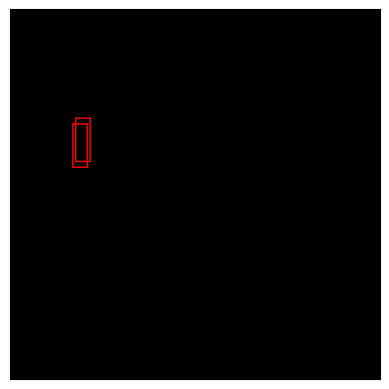

In [134]:
image = torch.rand(3, 256, 256)
x = torch.arange(45,55,0.1)
y = torch.arange(85,95,0.1)

bb = torch.tensor([[50,90,10,30],[48,94.5,10,30]])#[50,90,30,10] .unsqueeze(0)

bbox = torchvision.ops.box_convert(bb, in_fmt='cxcywh', out_fmt='xyxy')
print(torchvision.ops.box_iou(bbox[0].unsqueeze(0),bbox[1].unsqueeze(0)))
drawn_boxes = draw_bounding_boxes(image.to(torch.uint8), bbox, colors="red",width = 1, font_size=100)
show(drawn_boxes)


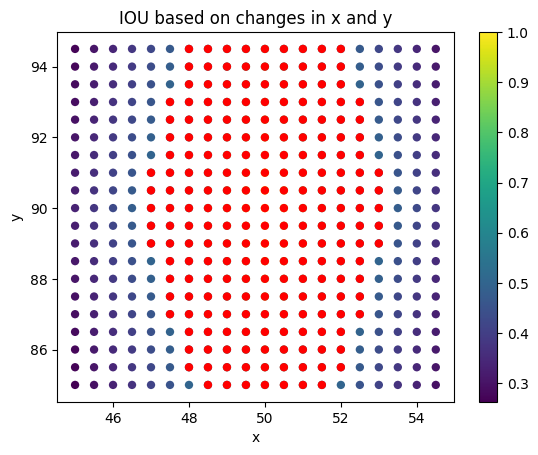

In [148]:
%matplotlib inline
image = torch.rand(3, 256, 256)
x = torch.arange(45,55,0.5)
y = torch.arange(85,95,0.5)
# x = np.array([48,52])
# y = np.array([85,95])
mesh = torch.meshgrid(x,y)
bb1  = torch.tensor([[50,90,10,30]])
bb1 = torchvision.ops.box_convert(bb1, in_fmt='cxcywh', out_fmt='xyxy')
IOUs = []
threshold_idx = []
for i in range(len(x)):
    for j in range(len(y)):
        bb2 = torch.tensor([[x[i],y[j],10,30]])
        # print(bb2)
        bb2 = torchvision.ops.box_convert(bb2, in_fmt='cxcywh', out_fmt='xyxy')
        iou_val = torchvision.ops.box_iou(bb1,bb2)
        IOUs.append(iou_val)
        if iou_val>0.5:
            threshold_idx.append((i,j))


# plt.figure(figsize=(8, 6))
cmap = 'viridis'#'Blues'
plt.scatter(mesh[0], mesh[1], c=IOUs, cmap=cmap, edgecolor='none')
plt.colorbar()

# print(threshold_idx)
for [i,j] in threshold_idx:
    plt.scatter(x[i], y[j], c='red', edgecolor='none')

plt.xlabel('x')
plt.ylabel('y')
plt.title('IOU based on changes in x and y')
# show color scale
plt.show()

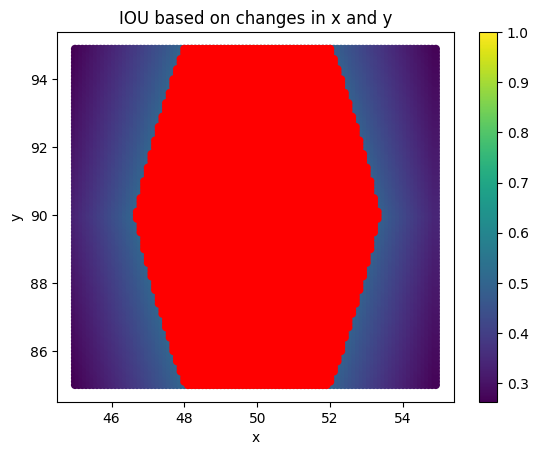

In [147]:
cmap = 'viridis'#'Blues'
plt.scatter(mesh[0], mesh[1], c=IOUs, cmap=cmap, edgecolor='none')
plt.colorbar()

# print(threshold_idx)
for [i,j] in threshold_idx:
    plt.scatter(x[i], y[j], c='red', edgecolor='none')

plt.xlabel('x')
plt.ylabel('y')
plt.title('IOU based on changes in x and y')
# show color scale
plt.show()

In [2]:
with open('PCB-Components-1495/data.yaml') as f:
        data = yaml.safe_load(f)
label_names = data['names']
len(label_names)

4495

In [13]:
with open('PCB-Components-1495/data.yaml') as f:
        data = yaml.safe_load(f)
label_names = data['names']
dd = CustomImageDataset("/home/newmatik/PCB Defect/Algorithm/PCB-Components-1495/train/labels","/home/newmatik/PCB Defect/Algorithm/PCB-Components-1495/train/images")
training_loader = DataLoader(dd, batch_size=1,
                        shuffle=True, num_workers=0)

 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.train()
unning_loss = 0.
last_loss = 0.

# Here, we use enumerate(training_loader) instead of
# iter(training_loader) so that we can track the batch
# index and do some intra-epoch reporting
# for i, data in enumerate(training_loader):
# Every data instance is an input + label pair
data = next(iter(training_loader))
inputs, labels = data

# Zero your gradients for every batch!
optimizer.zero_grad()

# Make predictions for this batch
outputs = model(inputs,labels)

# Compute the loss and its gradients
# loss = loss_fn(outputs, labels)
# loss.backward()

# # Adjust learning weights
# optimizer.step()

# # Gather data and report
# running_loss += loss.item()
# if i % 1000 == 999:
#         last_loss = running_loss / 1000 # loss per batch
#         print('  batch {} loss: {}'.format(i + 1, last_loss))
#         tb_x = epoch_index * len(training_loader) + i + 1
#         tb_writer.add_scalar('Loss/train', last_loss, tb_x)
#         running_loss = 0.



AssertionError: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([1, 1, 4]).

In [22]:
# # idx = np.argsort(-label_hist)[:-1]
idx = np.where(label_hist>10)[0]
# print(idx)
print('index of max label:', np.argsort(-label_hist)[:2])
print('label name:',label_names[np.argsort(-label_hist)[0]],label_names[np.argsort(-label_hist)[1]])#np.argmax(label_hist)])
# print('-----------')
# print(idx[0])
hist = label_hist[idx]
names = np.array(label_names)[idx]
# plt.scatter(idx,hist)
# print(names)
# set(All_labels)

index of max label: [1803  736]
label name: resistor IR1 capacitor 1V5


[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 

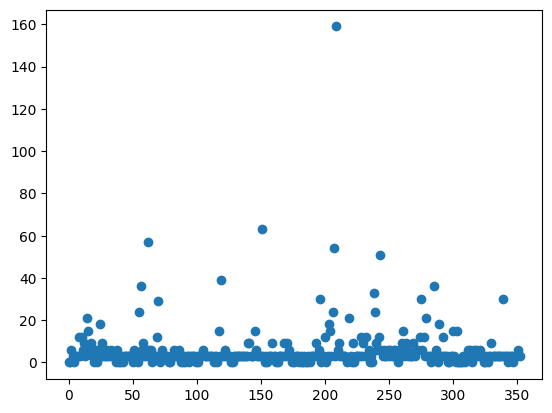

In [32]:
text_indices = []
for i,l in enumerate(label_names):
    if '-component text-' in l:
        # print(l)
        text_indices.append(i)



    